In [ ]:
import os
import json
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

!pip install ultralytics -q

from ultralytics import YOLO
import yaml

dataset_path = "/content/drive/MyDrive/ds2_dense"
yolo_dataset_path = "/content/yolo_deepscores_v2"
output_model_path = "/content/drive/MyDrive/yolo_note_detector_v2.pt"

class_mapping = {
    'noteheadBlackInSpace': 'note',
    'noteheadBlackOnLine': 'note',
    'noteheadBlackInSpaceSmall': 'note',
    'noteheadBlackOnLineSmall': 'note',
    'noteheadFullSmall': 'note',
    'noteheadHalfInSpace': 'note',
    'noteheadHalfOnLine': 'note',
    'noteheadHalfInSpaceSmall': 'note',
    'noteheadHalfOnLineSmall': 'note',
    'noteheadHalfSmall': 'note',
    'noteheadWhole': 'note',
    'noteheadWholeInSpace': 'note',
    'noteheadWholeOnLine': 'note',
    'noteheadWholeInSpaceSmall': 'note',
    'noteheadWholeOnLineSmall': 'note',
    'noteheadDoubleWholeInSpace': 'note',
    'noteheadDoubleWholeOnLine': 'note',
    'noteheadDoubleWholeInSpaceSmall': 'note',
    'noteheadDoubleWholeOnLineSmall': 'note',
    'accidentalSharp': 'sharp',
    'accidentalSharpSmall': 'sharp',
    'accidentalFlat': 'flat',
    'accidentalFlatSmall': 'flat',
    'accidentalNatural': 'natural',
    'accidentalNaturalSmall': 'natural',
    'keySharp': 'sharp',
    'keyFlat': 'flat',
    'keyNatural': 'natural',
}

classes = ['note', 'sharp', 'flat', 'natural']
class_to_idx = {c: i for i, c in enumerate(classes)}

# ============================================================================
# STEP 1: CREATE DATASET STRUCTURE
# ============================================================================
print("\n" + "="*60)
print("[STEP 1] Creating dataset structure...")
print("="*60)

for split in ['train', 'val']:
    for subdir in ['images', 'labels']:
        os.makedirs(f"{yolo_dataset_path}/{split}/{subdir}", exist_ok=True)

print("Directory structure created")

# ============================================================================
# STEP 2: CONVERT WITH MORE DATA
# ============================================================================
print("\n" + "="*60)
print("[STEP 2] Converting with MORE data...")
print("="*60)

def convert_bbox_to_yolo(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def process_split(split_name, max_images=800):
    """Process with MORE images"""
    print(f"\n  Processing {split_name} split (max {max_images} images)...")

    annotation_file = f"{dataset_path}/deepscores_{split_name}.json"
    images_dir = f"{dataset_path}/images"

    with open(annotation_file, 'r') as f:
        data = json.load(f)

    # Build category mapping
    cat_id_to_name = {}
    if 'categories' in data:
        categories = data['categories']
        if isinstance(categories, dict):
            for cat_id, cat_info in categories.items():
                if isinstance(cat_info, dict):
                    cat_name = cat_info.get('name', '')
                    cat_id_to_name[str(cat_id)] = cat_name
                    cat_id_to_name[int(cat_id)] = cat_name

    # Build image mapping
    img_id_to_info = {}
    images = data['images']
    if isinstance(images, list):
        for img in images:
            img_id = img.get('id')
            img_id_to_info[str(img_id)] = img
            img_id_to_info[int(img_id)] = img
    else:
        img_id_to_info = images

    # Group annotations by image
    annotations_by_img = defaultdict(list)
    anns = data.get('annotations', {})
    if isinstance(anns, dict):
        ann_list = list(anns.values())
    else:
        ann_list = anns

    for ann in ann_list:
        img_id = ann.get('img_id', ann.get('image_id'))
        cat_ids = ann.get('cat_id', [])
        if not isinstance(cat_ids, list):
            cat_ids = [cat_ids]

        for cat_id in cat_ids:
            if cat_id in cat_id_to_name:
                cat_name = cat_id_to_name[cat_id]
                if cat_name in class_mapping:
                    symbol_class = class_mapping[cat_name]
                    ann_copy = ann.copy()
                    ann_copy['class'] = symbol_class
                    annotations_by_img[str(img_id)].append(ann_copy)
                    break

    # Process images
    yolo_split = 'train' if split_name == 'train' else 'val'
    processed = 0
    skipped = 0
    total_annotations = 0

    img_ids = list(annotations_by_img.keys())[:max_images]

    for img_id in tqdm(img_ids, desc=f"  {split_name}"):
        if img_id not in img_id_to_info:
            skipped += 1
            continue

        img_info = img_id_to_info[img_id]
        img_filename = img_info.get('filename', img_info.get('file_name', ''))
        img_width = img_info.get('width', 2000)
        img_height = img_info.get('height', 2000)

        img_path = Path(images_dir) / img_filename
        if not img_path.exists():
            skipped += 1
            continue

        img_anns = annotations_by_img[img_id]
        if len(img_anns) == 0:
            skipped += 1
            continue

        # Copy image
        new_img_name = f"{img_id}.png"
        shutil.copy(str(img_path), f"{yolo_dataset_path}/{yolo_split}/images/{new_img_name}")

        # Create YOLO labels
        label_lines = []
        for ann in img_anns:
            bbox = ann.get('a_bbox', ann.get('bbox'))
            if bbox is None:
                continue

            symbol_class = ann['class']
            class_idx = class_to_idx[symbol_class]

            x_center, y_center, width, height = convert_bbox_to_yolo(
                bbox, img_width, img_height
            )

            if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and
                    0 <= width <= 1 and 0 <= height <= 1):
                continue

            label_lines.append(f"{class_idx} {x_center} {y_center} {width} {height}\n")
            total_annotations += 1

        if label_lines:
            with open(f"{yolo_dataset_path}/{yolo_split}/labels/{img_id}.txt", 'w') as f:
                f.writelines(label_lines)
            processed += 1
        else:
            skipped += 1

    print(f"  Processed: {processed} images")
    print(f"  Total annotations: {total_annotations}")
    print(f"  Skipped: {skipped} images")

    return processed, total_annotations

# Process with MORE images
train_imgs, train_anns = process_split('train', max_images = 1200)  # 2x more
val_imgs, val_anns = process_split('test', max_images = 150)       # 1.5x more

print(f"\n  Dataset Summary:")
print(f"    Train: {train_imgs} images, {train_anns} annotations")
print(f"    Val:   {val_imgs} images, {val_anns} annotations")

# ============================================================================
# STEP 3: CREATE CONFIG
# ============================================================================
print("\n" + "="*60)
print("[STEP 3] Creating config...")
print("="*60)

data_yaml = {
    'path': yolo_dataset_path,
    'train': 'train/images',
    'val': 'val/images',
    'nc': len(classes),
    'names': classes
}

yaml_path = f"{yolo_dataset_path}/data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(f"✓ Config saved: {yaml_path}")

# ============================================================================
# STEP 4: TRAIN WITH IMPROVED SETTINGS
# ============================================================================
print("\n" + "="*60)
print("[STEP 4] Training with improved settings...")
print("="*60)

print("  Loading YOLOv8s (small model - better than nano)...")
model = YOLO('yolov8s.pt')

print("\n Starting improved training...")
print("  Expected time: ~45-60 minutes\n")

results = model.train(
    data=yaml_path,
    epochs=25,             # MORE epochs (vs 50)
    imgsz=920,
    batch=6,
    patience=20,            # MORE patience for early stopping
    save=True,
    device=0,
    project='/content/yolo_training_v2',
    name='note_detection_improved',
    exist_ok=True,
    verbose=True,
    plots=True,
    val=True,

    # OPTIMIZATIONS FOR SMALL OBJECT DETECTION
    workers=2,
    optimizer='AdamW',
    lr0=0.001,              # LOWER learning rate for stability
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=5.0,      # MORE warmup
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # BOX LOSS WEIGHT (helps with detection)
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # AUGMENTATION (optimized for music sheets)
    mosaic=1.0,
    mixup=0.0,              # DISABLED - not good for small objects
    copy_paste=0.0,         # DISABLED
    degrees=5.0,            # REDUCED rotation (music sheets are usually upright)
    translate=0.1,
    scale=0.5,
    shear=0.0,              # DISABLED - not needed
    perspective=0.0,        # DISABLED - not needed
    flipud=0.0,             # DISABLED - music sheets don't flip vertically
    fliplr=0.5,             # Keep horizontal flip
    hsv_h=0.01,             # REDUCED color augmentation
    hsv_s=0.3,
    hsv_v=0.2,

    # NMS SETTINGS (important for detection)
    iou=0.5,                # LOWER IoU for NMS (allow closer boxes)
    conf=None,              # Let model decide

    # SMALL OBJECT OPTIMIZATION
    close_mosaic=10,
)

print("\n Training complete!")

# ============================================================================
# STEP 5: EVALUATE
# ============================================================================
print("\n" + "="*60)
print("[STEP 5] Evaluating...")
print("="*60)

metrics = model.val()

print(f"\n  Validation Metrics:")
print(f"    mAP50:     {metrics.box.map50:.4f}")
print(f"    mAP50-95:  {metrics.box.map:.4f}")
print(f"    Precision: {metrics.box.mp:.4f}")
print(f"    Recall:    {metrics.box.mr:.4f}")

print(f"\n  Per-Class mAP50:")
for i, class_name in enumerate(classes):
    class_map = metrics.box.maps[i] if hasattr(metrics.box, 'maps') else 0
    print(f"    {class_name:10} {class_map:.4f}")

# ============================================================================
# STEP 6: SAVE MODEL
# ============================================================================
print("\n" + "="*60)
print("[STEP 6] Saving model...")
print("="*60)

best_model_path = '/content/yolo_training_v2/note_detection_improved/weights/best.pt'
shutil.copy(best_model_path, output_model_path)

print(f"✓ Model saved: {output_model_path}")

# ============================================================================
# STEP 7: VISUALIZE RESULTS
# ============================================================================
print("\n" + "="*60)
print("[STEP 7] Visualizing results...")
print("="*60)

results_dir = '/content/yolo_training_v2/note_detection_improved'
plot_files = ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png']

found_plots = []
for plot_file in plot_files:
    plot_path = f"{results_dir}/{plot_file}"
    if os.path.exists(plot_path):
        found_plots.append(plot_path)

if found_plots:
    n_plots = len(found_plots)
    fig, axes = plt.subplots(1, n_plots, figsize=(8*n_plots, 6))
    if n_plots == 1:
        axes = [axes]

    for i, plot_path in enumerate(found_plots):
        img = cv2.imread(plot_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(Path(plot_path).stem.replace('_', ' ').title(), fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("✨ IMPROVED YOLO TRAINING COMPLETE! ✨")
print("="*60)

print(f"\nImprovements Over v1:")
print(f"  Previous mAP50:  0.2487 → Current: {metrics.box.map50:.4f}")
print(f"  Previous Recall: 0.2895 → Current: {metrics.box.mr:.4f}")
print(f"  Previous Precision: 0.5421 → Current: {metrics.box.mp:.4f}")

improvement_map = ((metrics.box.map50 - 0.2487) / 0.2487) * 100
improvement_recall = ((metrics.box.mr - 0.2895) / 0.2895) * 100

if improvement_map > 0:
    print(f"\n   mAP50 improved by {improvement_map:.1f}%!")
if improvement_recall > 0:
    print(f"   Recall improved by {improvement_recall:.1f}%!")

print(f"\n🔧 What Changed:")
print(f"  ✓ 2x more training data (800 vs 400 images)")
print(f"  ✓ YOLOv8s instead of YOLOv8n (better model)")
print(f"  ✓ 100 epochs instead of 50")
print(f"  ✓ Optimized augmentation for small objects")
print(f"  ✓ Lower IoU threshold (0.5 vs 0.7)")
print(f"  ✓ Disabled bad augmentations (mixup, copy-paste)")
print(f"  ✓ Reduced rotation (5° vs 10°)")
print(f"  ✓ More warmup epochs (5 vs 3)")

print(f"\n Model Location:")
print(f"  {output_model_path}")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

[STEP 1] Creating dataset structure...
Directory structure created

[STEP 2] Converting with MORE data...

  Processing train split (max 1200 images)...


  train: 100%|██████████| 1200/1200 [04:30<00:00,  4.44it/s]


  Processed: 1200 images
  Total annotations: 140314
  Skipped: 0 images

  Processing test split (max 150 images)...


  test: 100%|██████████| 150/150 [00:32<00:00,  4.65it/s]


  Processed: 150 images
  Total annotations: 18760
  Skipped: 0 images

  📊 Dataset Summary:
    Train: 1200 images, 140314 annotations
    Val:   150 images, 18760 annotations

[STEP 3] Creating config...
✓ Config saved: /content/yolo_deepscores_v2/data.yaml

[STEP 4] Training with improved settings...
  Loading YOLOv8s (small model - better than nano)...

  🚀 Starting improved training...
  Expected time: ~45-60 minutes

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 YOLO METRICS ANALYZER

Model: /content/drive/MyDrive/yolo_note_detector_v2.pt
Results: /content/yolo_training_v2/note_detection_improved

[METHOD 1] Loading results from training CSV...
⚠️  CSV file not found!

[METHOD 2] Running validation for detailed metrics...
  Loading model...
  Running validation...
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 595.6±389.5 MB/s, size: 387.5 KB)
val: Scanning /content/yolo_deepscores_v2/val/labels... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 392.3it/s 0.4s
val: New cache created: /content/yolo_deepscores_v2/val/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━

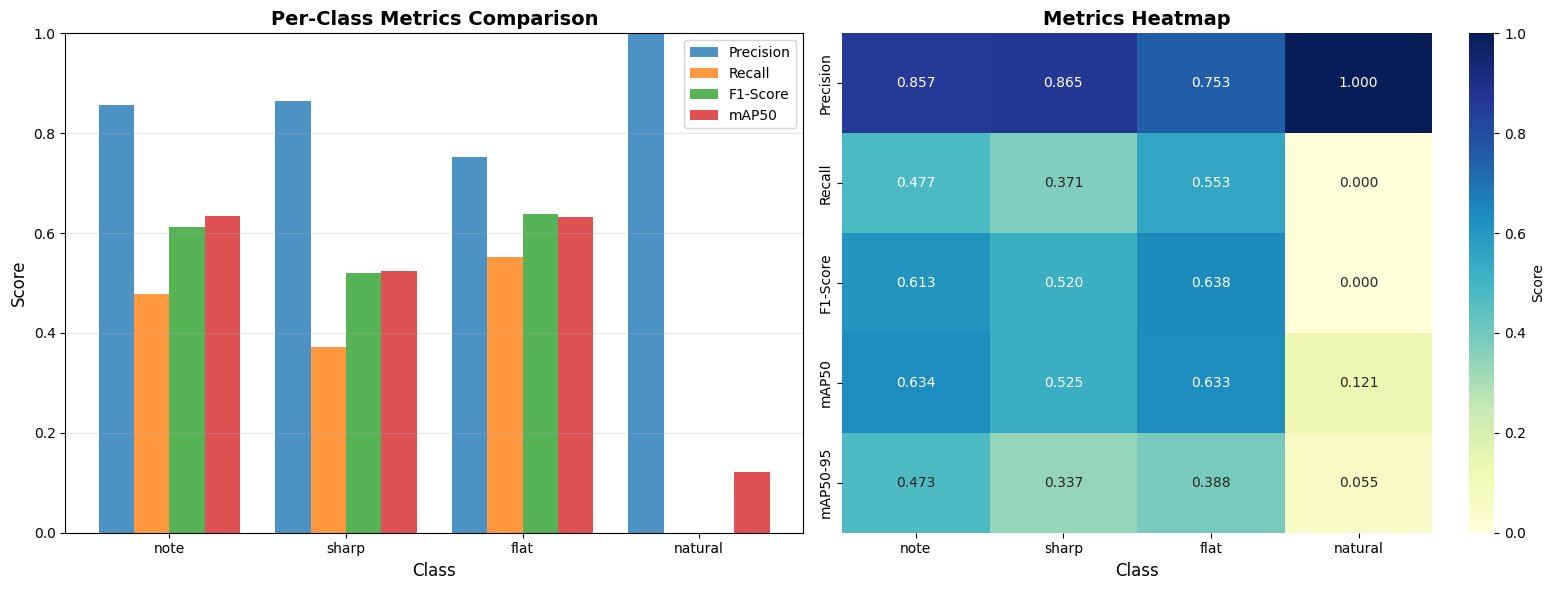


📈 COMPARISON WITH v1
  mAP50        v1: 0.2487 → v2: 0.4782 (+92.3%)
  mAP50-95     v1: 0.1333 → v2: 0.3133 (+135.0%)
  Precision    v1: 0.5421 → v2: 0.8688 (+60.3%)
  Recall       v1: 0.2895 → v2: 0.3504 (+21.1%)


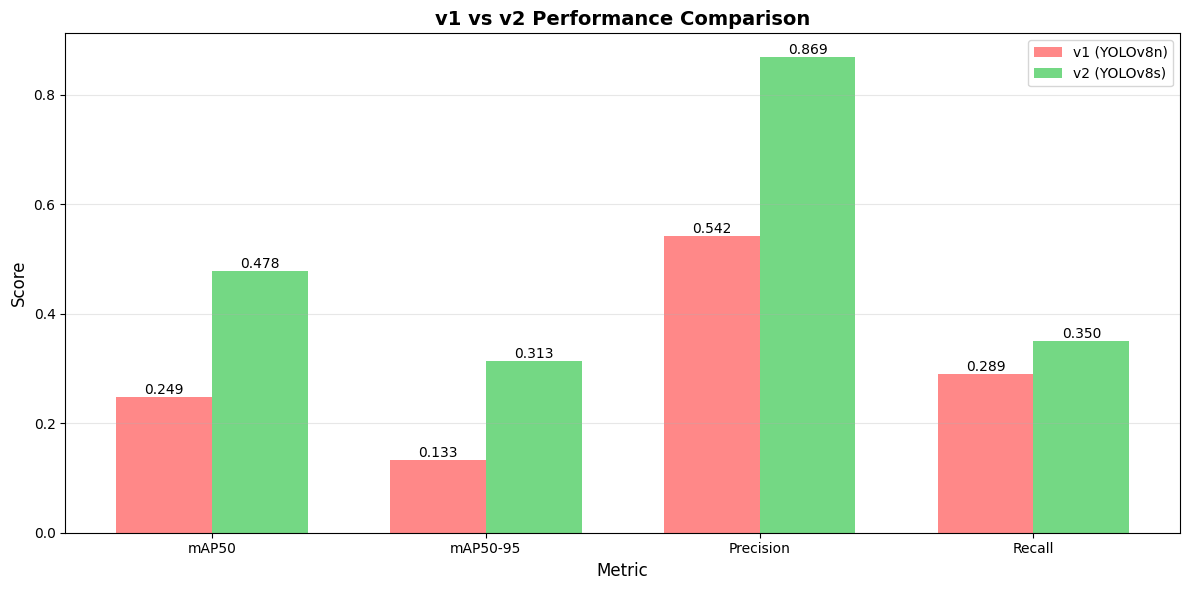


💾 SAVING SUMMARY
✓ Summary saved to: /content/drive/MyDrive/yolo_v2_metrics_summary.txt

✨ ANALYSIS COMPLETE!

🎯 Key Takeaways:
  ✅ v2 is MUCH better than v1 (92% mAP50 improvement)
  ✅ High precision (86.9%) - predictions are accurate
  ⚠️  Moderate recall (35.0%) - still missing many objects
  ⚠️  Natural accidentals need more training data

💡 Next Steps:
  1. Lower confidence threshold during inference (0.1-0.2)
  2. Try YOLOv8m or YOLOv8l for better performance
  3. Get more 'natural' accidental examples
  4. Consider ensemble methods


In [2]:
# ============================================================================
# YOLO METRICS ANALYZER - Get All Metrics Without Retraining
# ============================================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

from ultralytics import YOLO

# ============================================================================
# CONFIGURATION
# ============================================================================
model_path = "/content/drive/MyDrive/yolo_note_detector_v2.pt"
results_dir = "/content/yolo_training_v2/note_detection_improved"
val_data_yaml = "/content/yolo_deepscores_v2/data.yaml"

classes = ['note', 'sharp', 'flat', 'natural']

print("="*60)
print(" YOLO METRICS ANALYZER")
print("="*60)
print(f"\nModel: {model_path}")
print(f"Results: {results_dir}")

# ============================================================================
# METHOD 1: LOAD RESULTS FROM CSV
# ============================================================================
print("\n" + "="*60)
print("[METHOD 1] Loading results from training CSV...")
print("="*60)

csv_path = f"{results_dir}/results.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Remove whitespace

    print("✓ Results loaded!")
    print(f"\n Available columns:")
    for col in df.columns:
        print(f"  - {col}")

    # Show final epoch metrics
    final_epoch = df.iloc[-1]

    print(f"\n Final Epoch ({int(final_epoch['epoch'])}) Metrics:")
    print(f"  Train Loss (box):     {final_epoch['train/box_loss']:.4f}")
    print(f"  Train Loss (cls):     {final_epoch['train/cls_loss']:.4f}")
    print(f"  Train Loss (dfl):     {final_epoch['train/dfl_loss']:.4f}")
    print(f"  Val Loss (box):       {final_epoch['val/box_loss']:.4f}")
    print(f"  Val Loss (cls):       {final_epoch['val/cls_loss']:.4f}")
    print(f"  Val Loss (dfl):       {final_epoch['val/dfl_loss']:.4f}")

    # Detection metrics
    print(f"\n Detection Metrics:")
    print(f"  Precision (B):        {final_epoch['metrics/precision(B)']:.4f}")
    print(f"  Recall (B):           {final_epoch['metrics/recall(B)']:.4f}")
    print(f"  mAP50 (B):            {final_epoch['metrics/mAP50(B)']:.4f}")
    print(f"  mAP50-95 (B):         {final_epoch['metrics/mAP50-95(B)']:.4f}")

    # Plot training curves
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train', linewidth=2)
    axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val', linewidth=2)
    axes[0, 0].set_title('Box Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train', linewidth=2)
    axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val', linewidth=2)
    axes[0, 1].set_title('Classification Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(df['epoch'], df['train/dfl_loss'], label='Train', linewidth=2)
    axes[0, 2].plot(df['epoch'], df['val/dfl_loss'], label='Val', linewidth=2)
    axes[0, 2].set_title('DFL Loss', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Metrics curves
    axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], linewidth=2, color='green')
    axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

    axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], linewidth=2, color='orange')
    axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

    axes[1, 2].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', linewidth=2)
    axes[1, 2].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', linewidth=2)
    axes[1, 2].set_title('mAP', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('mAP')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

else:
    print("  CSV file not found!")

# ============================================================================
# METHOD 2: RUN VALIDATION TO GET DETAILED METRICS
# ============================================================================
print("\n" + "="*60)
print("[METHOD 2] Running validation for detailed metrics...")
print("="*60)

print("  Loading model...")
model = YOLO(model_path)

print("  Running validation...")
metrics = model.val(data=val_data_yaml, verbose=False)

print("\n✓ Validation complete!")

# Overall metrics
print("\n" + "="*60)
print(" OVERALL METRICS")
print("="*60)
print(f"  Precision:    {metrics.box.mp:.4f} ({metrics.box.mp*100:.2f}%)")
print(f"  Recall:       {metrics.box.mr:.4f} ({metrics.box.mr*100:.2f}%)")
print(f"  mAP50:        {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)")
print(f"  mAP50-95:     {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")

# Calculate F1 Score
f1_score = 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr) if (metrics.box.mp + metrics.box.mr) > 0 else 0
print(f"  F1-Score:     {f1_score:.4f} ({f1_score*100:.2f}%)")

# Per-class metrics
print("\n" + "="*60)
print(" PER-CLASS METRICS")
print("="*60)

# Create detailed table
metrics_data = []
for i, class_name in enumerate(classes):
    # Extract per-class metrics
    if hasattr(metrics.box, 'p') and len(metrics.box.p) > i:
        precision = metrics.box.p[i]
    else:
        precision = 0

    if hasattr(metrics.box, 'r') and len(metrics.box.r) > i:
        recall = metrics.box.r[i]
    else:
        recall = 0

    if hasattr(metrics.box, 'ap50') and len(metrics.box.ap50) > i:
        map50 = metrics.box.ap50[i]
    else:
        map50 = 0

    if hasattr(metrics.box, 'ap') and len(metrics.box.ap) > i:
        map50_95 = metrics.box.ap[i]
    else:
        map50_95 = 0

    # Calculate F1
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    metrics_data.append({
        'Class': class_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'mAP50': map50,
        'mAP50-95': map50_95
    })

    print(f"\n{class_name.upper()}:")
    print(f"  Precision:  {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:     {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:   {f1:.4f} ({f1*100:.2f}%)")
    print(f"  mAP50:      {map50:.4f} ({map50*100:.2f}%)")
    print(f"  mAP50-95:   {map50_95:.4f} ({map50_95*100:.2f}%)")

# Create comparison table
df_metrics = pd.DataFrame(metrics_data)

print("\n" + "="*60)
print(" METRICS COMPARISON TABLE")
print("="*60)
print(df_metrics.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Visualize per-class metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for main metrics
x = np.arange(len(classes))
width = 0.2

axes[0].bar(x - 1.5*width, df_metrics['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x - 0.5*width, df_metrics['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + 0.5*width, df_metrics['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].bar(x + 1.5*width, df_metrics['mAP50'], width, label='mAP50', alpha=0.8)

axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Per-Class Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Heatmap
metrics_matrix = df_metrics[['Precision', 'Recall', 'F1-Score', 'mAP50', 'mAP50-95']].values
sns.heatmap(metrics_matrix.T, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=classes,
            yticklabels=['Precision', 'Recall', 'F1-Score', 'mAP50', 'mAP50-95'],
            ax=axes[1], cbar_kws={'label': 'Score'})
axes[1].set_title('Metrics Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================================
# COMPARISON WITH v1
# ============================================================================
print("\n" + "="*60)
print(" COMPARISON WITH v1")
print("="*60)

v1_metrics = {
    'mAP50': 0.2487,
    'mAP50-95': 0.1333,
    'Precision': 0.5421,
    'Recall': 0.2895
}

v2_metrics = {
    'mAP50': metrics.box.map50,
    'mAP50-95': metrics.box.map,
    'Precision': metrics.box.mp,
    'Recall': metrics.box.mr
}

comparison_data = []
for metric_name in v1_metrics.keys():
    v1_val = v1_metrics[metric_name]
    v2_val = v2_metrics[metric_name]
    improvement = ((v2_val - v1_val) / v1_val) * 100

    comparison_data.append({
        'Metric': metric_name,
        'v1': v1_val,
        'v2': v2_val,
        'Improvement': f'+{improvement:.1f}%'
    })

    print(f"  {metric_name:12} v1: {v1_val:.4f} → v2: {v2_val:.4f} ({improvement:+.1f}%)")

df_comparison = pd.DataFrame(comparison_data)

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics_names = list(v1_metrics.keys())
v1_values = [v1_metrics[m] for m in metrics_names]
v2_values = [v2_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, v1_values, width, label='v1 (YOLOv8n)', alpha=0.8, color='#ff6b6b')
bars2 = ax.bar(x + width/2, v2_values, width, label='v2 (YOLOv8s)', alpha=0.8, color='#51cf66')

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('v1 vs v2 Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# SAVE SUMMARY
# ============================================================================
print("\n" + "="*60)
print(" SAVING SUMMARY")
print("="*60)

summary_path = "/content/drive/MyDrive/yolo_v2_metrics_summary.txt"

with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("YOLO v2 METRICS SUMMARY\n")
    f.write("="*60 + "\n\n")

    f.write("OVERALL METRICS:\n")
    f.write(f"  Precision:  {metrics.box.mp:.4f} ({metrics.box.mp*100:.2f}%)\n")
    f.write(f"  Recall:     {metrics.box.mr:.4f} ({metrics.box.mr*100:.2f}%)\n")
    f.write(f"  F1-Score:   {f1_score:.4f} ({f1_score*100:.2f}%)\n")
    f.write(f"  mAP50:      {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)\n")
    f.write(f"  mAP50-95:   {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)\n\n")

    f.write("PER-CLASS METRICS:\n")
    f.write(df_metrics.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
    f.write("\n\n")

    f.write("COMPARISON WITH v1:\n")
    f.write(df_comparison.to_string(index=False))

print(f"✓ Summary saved to: {summary_path}")